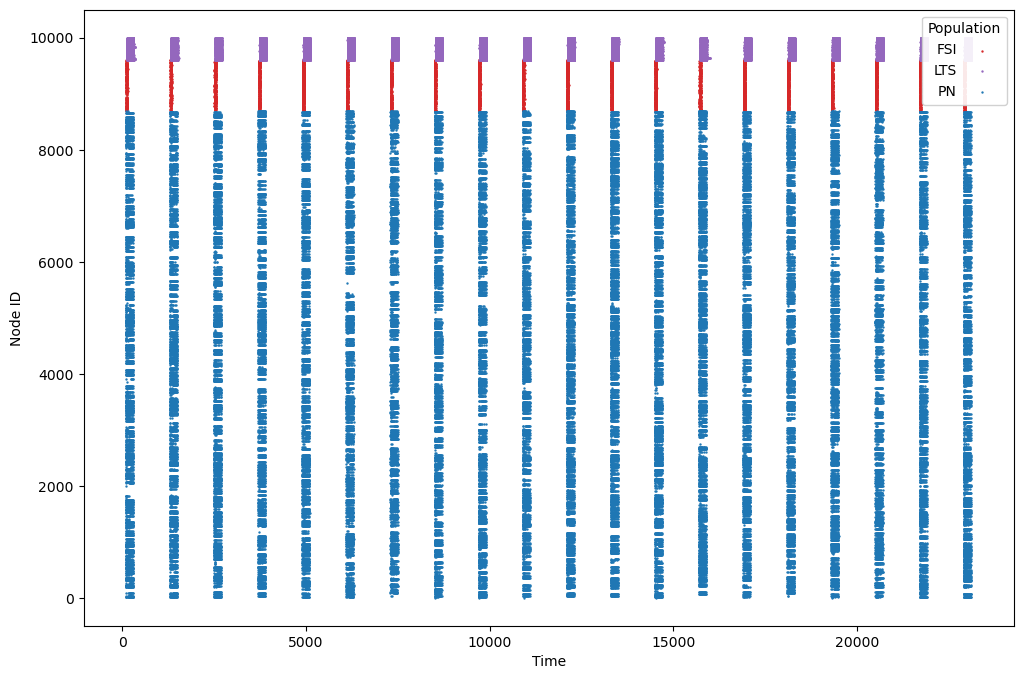

In [39]:
from bmtool.analysis.lfp import load_ecp_to_xarray,ecp_to_lfp,fit_fooof,wavelet_filter,slice_time_series
from bmtool.bmplot import raster
from bmtool.analysis.spikes import load_spikes_to_df
import matplotlib.pyplot as plt
import scipy.signal as ss
import numpy as np
import h5py
import sys
sys.path.append("../../..")
#%matplotlib widget

input_type = "stable"
output_path = f"../Run-Storage/opto_{input_type}"

def get_voltage_data(file_path,target_gid):
    with h5py.File(file_path, 'r') as f:

        #Load the relevant datasets
        stim_data = f['report']['cortex']['data']
        mapping=f['report']['cortex']['mapping']  
        gids = mapping['node_ids']
        
        time = np.arange(mapping['time'][0],mapping['time'][1],mapping['time'][2])
        
        # Check if the target GID exists in the gids array
        if target_gid not in gids[:]:
            raise ValueError(f"GID {target_gid} not found in the dataset.")

        # Find the index of the target GID in the gids array
        site_idx = (gids[:] == target_gid).nonzero()[0][0]  # Find the index of the GID

        # Retrieve the current for the given GID across all time steps
        current = stim_data[:, site_idx]  

        return time, current
    
# time,voltage = get_voltage_data(f"{output_path}v_traces.h5",target_gid=8002)
# plt.plot(time,voltage)
# plt.show()

config_path = f"../Model-Parameters/simulation_config_stable.json"
_, ax = plt.subplots(1, 1, figsize=(12, 8))
pop_color = {'PN':'tab:blue','FSI':'tab:red','LTS':'tab:purple'}
spikes_df = load_spikes_to_df(f'{output_path}/spikes.h5', 'cortex',config=config_path)
raster(spikes_df,config=config_path, network_name='cortex',ax=ax,color_map=pop_color)
plt.show()

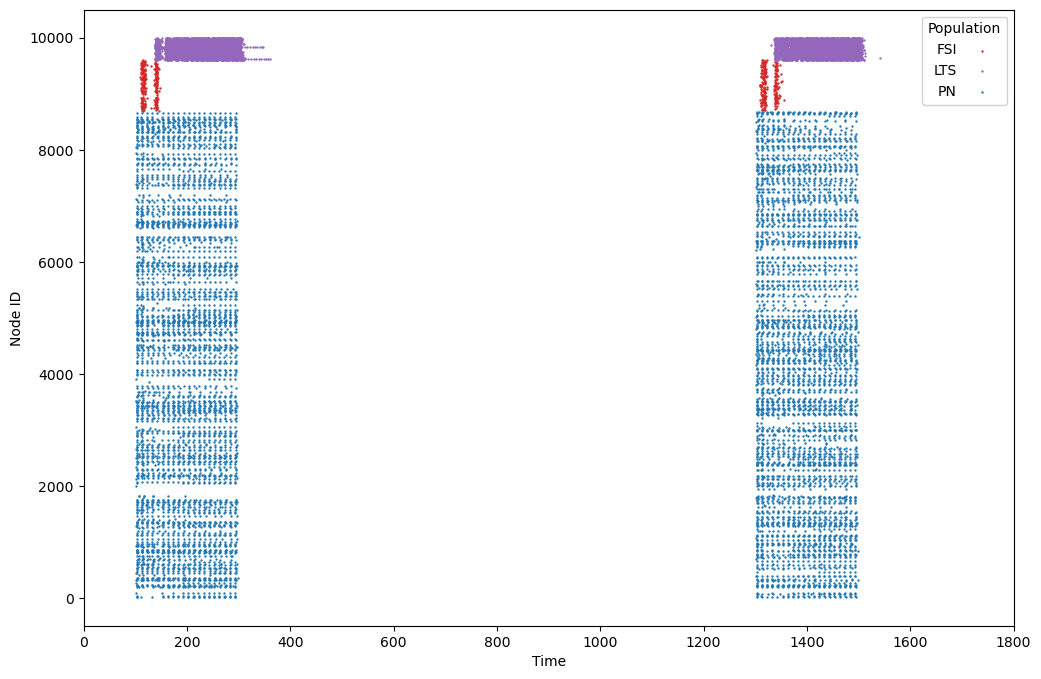

In [40]:
_, ax = plt.subplots(1, 1, figsize=(12, 8))
raster(spikes_df,config=config_path, network_name='cortex',ax=ax,color_map=pop_color)
plt.xlim(0,1800)
plt.show()

In [41]:
pn_spikes = spikes_df[spikes_df['pop_name']=='PN']

total_PNs = 8700
pn_spikes['node_ids'].nunique()

percent_spiked = pn_spikes['node_ids'].nunique()/total_PNs

display(f"Number of unique PN nodes to fire was {pn_spikes['node_ids'].nunique()} which is {percent_spiked:1.3f} of the network")
display(f"Number of PN spikes is {len(pn_spikes['timestamps'])}")

'Number of unique PN nodes to fire was 1557 which is 0.179 of the network'

'Number of PN spikes is 93811'

### The following analysis is done with only the time that the stimulation is present. We give a 200ms stimulation, then have a 500ms break in between the end of one stim and the start of the next stim

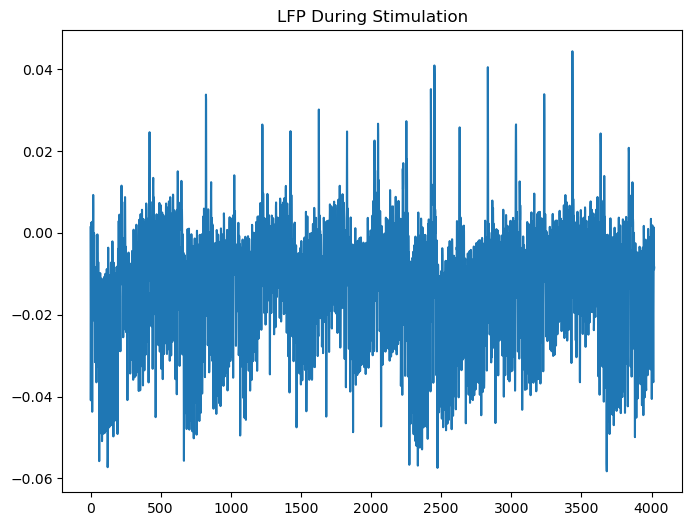

In [42]:
from bmtool.analysis.lfp import load_ecp_to_xarray,ecp_to_lfp,fit_fooof,wavelet_filter,slice_time_series

ecp = load_ecp_to_xarray(f"{output_path}/ecp.h5")
lfp = ecp_to_lfp(ecp)


stim_times = []
start = 100 #
end = 300
break_time = 1200
for i in range(20):
    stim_times.append((start,end))
    start += break_time 
    end += break_time
    
lfp = slice_time_series(lfp,stim_times)

_, ax = plt.subplots(1, 1, figsize=(8, 6))
plt.plot(lfp.sel(channel_id=0))
plt.title("LFP During Stimulation")
plt.show()

### FOOOF during stimulation

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 118 Hz                        
                                 Frequency Resolution is 3.91 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -5.7639, 0.4733                                          
                                                                                                  
                                       2 peaks were found:                                        
          

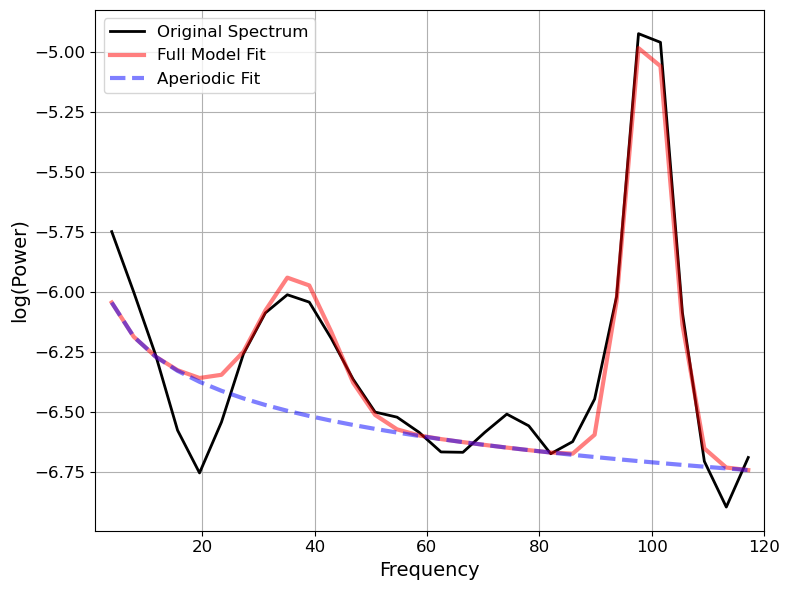

In [43]:
f,pxx= ss.welch(lfp.sel(channel_id=0),lfp.fs)

fooof_params = dict(aperiodic_mode='fixed', freq_range=(1,120), peak_width_limits=100.)
plt_range = fooof_params['freq_range']
plt_log = False
plt_db = True
figsize = (8, 6)

fooof_results, _ = fit_fooof(f,pxx,**fooof_params,report=True, plot=True, 
          plt_log=plt_log, plt_range=plt_range, figsize=figsize)

plt.show()

### spike rate fooof

Grabbing first network; specify a network name to ensure correct node population is selected.


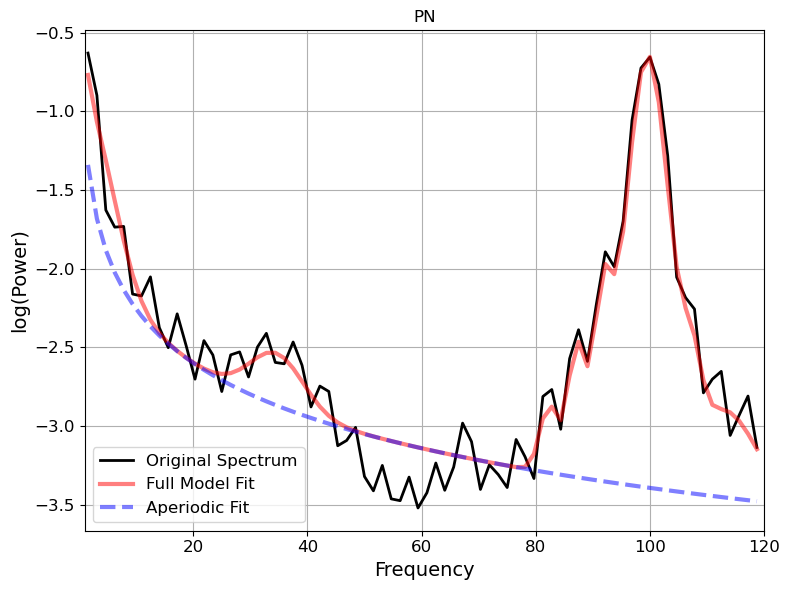

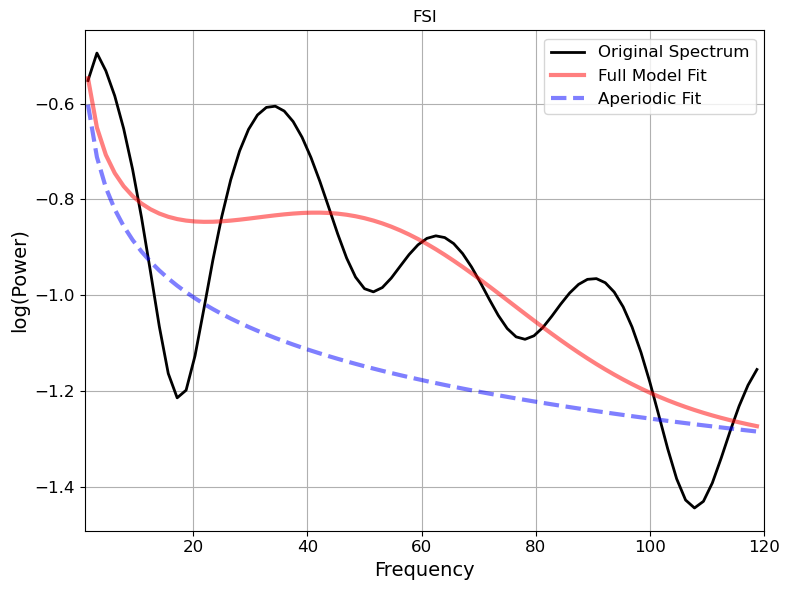

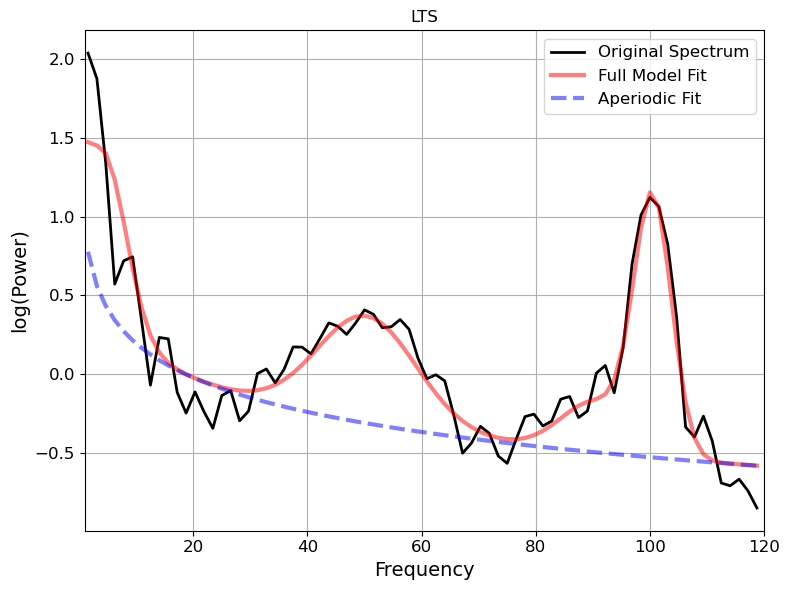

In [44]:
from bmtool.analysis.spikes import get_population_spike_rate
import matplotlib.pyplot as plt

spike_rates = get_population_spike_rate(spikes_df,config=config_path)
for pop_name,spike_rate in (spike_rates.items()):
    f,pxx= ss.welch(spike_rate,fs=400)
    fooof_results, _ = fit_fooof(f,pxx,**fooof_params,report=False, plot=True, 
          plt_log=plt_log, plt_range=plt_range, figsize=figsize,title=pop_name)
    

### Trial avg wavelet

## wavelet

In [45]:
# import numpy as np
# import matplotlib.pyplot as plt

# # parameters for spectral analysis
# start_freq = 1  # Hz
# end_freq = 100  # Hz
# num_freqs = 64  # number of frequencies to analyze

# # Create a range of frequencies logarithmically spaced
# freqs = np.geomspace(start_freq, end_freq, num_freqs)  # geometrically spaced frequencies
# t = np.arange(0, 4020, 1)  # time array

# spectra = []
# signal = lfp.sel(channel_id=0).values
# #signal = voltage[::10]

# # Iterate over the frequency range and compute the CWT for each frequency
# for freq in freqs:
#     # Compute the wavelet transform, taking the absolute value for magnitude
#     result = np.abs(wavelet_filter(x=signal, fs=lfp.fs, freq=freq))
#     spectra.append(result)

# spectra = np.array(spectra)  # Shape will be (num_freqs, num_timepoints)

# # Plotting the spectrogram
# fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# # Create the spectrogram using pcolormesh
# mag_map = ax.pcolormesh(t, freqs, spectra, shading='auto')

# # Add colorbar and labels
# fig.colorbar(mag_map, ax=ax, label="Magnitude")
# ax.set_xlabel("Time (s)")
# ax.set_ylabel("Frequency (Hz)")
# ax.set_title("Spectrogram (CWT)")

# plt.show()
